In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from rdkit import Chem
from rdkit.Chem import GetPeriodicTable, rdchem, rdEHTTools, rdmolops, rdDetermineBonds, AllChem, Draw

from ase.io import read, write


import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing, GraphNorm, BatchNorm, LayerNorm
from torch.nn import Parameter, ModuleList, Linear, ReLU, Dropout, MSELoss
from torch_geometric.utils import add_remaining_self_loops, remove_self_loops, softmax
from torch_geometric.utils import remove_self_loops, add_self_loops
import torch.optim as optim
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, make_scorer, mean_squared_error, r2_score

import copy
from collections import Counter

In [4]:
print("CUDA available:", torch.cuda.is_available())
print("Number of CUDA devices:", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(f"Device {i}: {torch.cuda.get_device_name(i)}")

CUDA available: True
Number of CUDA devices: 2
Device 0: NVIDIA A100-SXM4-40GB
Device 1: NVIDIA A100-SXM4-40GB


In [5]:
# All data containing 2267 complexes and redox potentials
full_data_df = pd.read_csv('../Data/tmqm_redox_data_full_data.csv')

# Mol and smiles of complexes generated after DFT-redox calculations
final_df = pd.read_pickle('../Data/tmc_frm_xyz2mol_tmqm_all_df.pkl')
final_df = final_df.drop_duplicates(subset='csd_code', keep='first')

In [6]:
full_data_df

,csd_code,q,Stoichiometry,num_atoms,ligands_list,tm_oxs,ligands_q_list,reduction_pot
0,HOLHUO,0,C12H14FeN4O10,41,"['Cc1nc(C(=O)[O-])c(C(=O)O)[nH]1', 'Cc1nc(C(=O...",2,"[-1, -1, 0, 0]",0.645236
1,UPOWOO,0,C17H21Cl2FeN3,44,"['CN1Cc2cccc(c2)CN(C)Cc2cccc(n2)C1', '[Cl-]', ...",2,"[0, -1, -1]",0.147820
2,TACSAU,0,C10H16Cl2FeN4Se2,35,"['Cn1ccn(C)c1=[Se]', 'Cn1ccn(C)c1=[Se]', '[Cl-...",2,"[0, 0, -1, -1]",-0.512239
3,LULSET,0,C11H12FeO3S2,29,"['CC(C)SC(=O)[S-]', '[C-]#[O+]', '[C-]#[O+]', ...",2,"[-1, 0, 0, -1]",0.900510
4,GESMAW,0,C8H3Br5FeO2,19,"['Brc1c(Br)c(Br)[c-](Br)c1Br', '[C-]#[O+]', '[...",2,"[-1, 0, 0, -1]",0.513174
...,...,...,...,...,...,...,...,...
2262,REGPEY,1,C30H26FeNOP2(1+),61,"['[C-]#[O+]', 'c1cc[cH-]c1', 'c1ccc(P(NP(c2ccc...",2,"[0, -1, 0]",1.105673
2263,HIKMIZ,1,C29H33FeNO2P(1+),67,"['CC(C)N(C(C)C)P1C(c2ccccc2)C=CC1c1ccccc1', '[...",2,"[0, 0, 0, -1]",1.560836
2264,SULPAQ,0,C22H21FeNO5Si,51,"['CN(C)Cc1ccccc1O[Si-]1Oc2ccccc2O1', '[C-]#[O+...",2,"[-1, 0, 0, -1]",1.234285
2265,ILOMAZ,0,C17H31FeN3OSi2,55,"['CC([O-])=CC(C)=NCc1ccccn1', 'C[Si](C)(C)[N-]...",2,"[-1, -1]",0.300287


In [7]:
# Filter out rows in final_df
rows_to_delete = []

for idx, row in final_df.iterrows():
    csd = row['csd_code']
    mol = row['mol']

    atoms = mol.GetAtoms()
    max_valence = 0
    Fe_charge = None
    for _, atom in enumerate(atoms):
        max_valence = atom.GetDegree() if atom.GetDegree() > max_valence else max_valence
        if atom.GetSymbol() == 'Fe':
            Fe_charge = atom.GetFormalCharge()

    if max_valence > 7:
        if idx not in rows_to_delete:
            rows_to_delete.append(idx)
    if Fe_charge > 3 or Fe_charge < 0:
        if idx not in rows_to_delete:
            rows_to_delete.append(idx)

# Drop rows from the dataframe
final_df = final_df.drop(rows_to_delete).reset_index(drop=True)

# Functions for Graph Generation

In [8]:
# Helper functions

from rdkit import Chem
from rdkit.Chem import AllChem, rdchem, rdFingerprintGenerator


def get_num_Hs(atom):
    """
    Returns the number of hydrogen atoms bonded to the given atom.
    """
    num_Hs = 0
    for neighbor in atom.GetNeighbors():
        if neighbor.GetAtomicNum() == 1:  # Atomic number 1 corresponds to hydrogen
            num_Hs += 1
    return num_Hs

    
def compute_morgan_fingerprint(mol, radius=3, fpSize=2048):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fpSize)
    morgan_fp = mfpgen.GetFingerprint(mol) # Get the fingerprint object
    # Convert ExplicitBitVect to NumPy array
    np_fp = np.array(list(morgan_fp))#, dtype=float)
    return np_fp # Return the NumPy array

# Creating dataset

# Define constants for hybridizations and stereoisomers
hybridizations = [
            Chem.rdchem.HybridizationType.S,
            Chem.rdchem.HybridizationType.SP,
            Chem.rdchem.HybridizationType.SP2,
            Chem.rdchem.HybridizationType.SP3,
            Chem.rdchem.HybridizationType.SP3D,
            Chem.rdchem.HybridizationType.SP3D2,
            Chem.rdchem.HybridizationType.UNSPECIFIED
        ]

stereos = [rdchem.BondStereo.STEREONONE, rdchem.BondStereo.STEREOANY,
           rdchem.BondStereo.STEREOZ, rdchem.BondStereo.STEREOE]

# Define periodic table for atomic properties
periodic_table = Chem.GetPeriodicTable()


def GenGraphs(df, mfp_mask=None, mfp_radius = 3, mfp_bits = 2048):
    data_list = []
    
    # Mols
    mol_list = df['mol'].tolist()
    
    # Graph features
    #homoE_list = df['HOMO_Energy'].tolist()
    #lumoE_list = df['LUMO_Energy'].tolist()
    #polarize_list = df['Polarizability'].tolist()
    #electronic_E_list = df['Electronic_E'].tolist()
    #dispersion_E_list = df['Dispersion_E'].tolist()

    smiles_list = df['smiles'].tolist()
    
    # target
    y_list = df['y'].tolist()

    
    for idx, mol in enumerate(mol_list):
        
        y = y_list[idx]
        y = torch.tensor(y, dtype=torch.float).view(-1, 1)

        #homoE = torch.tensor([homoE_list[idx]], dtype=torch.float)
        #lumoE = torch.tensor([lumoE_list[idx]], dtype=torch.float)
        #polarize = torch.tensor([polarize_list[idx]], dtype=torch.float)
        #electronic_E = torch.tensor([electronic_E_list[idx]], dtype=torch.float)
        #dispersion_E = torch.tensor([dispersion_E_list[idx]], dtype=torch.float)
    

        smiles = smiles_list[idx]
        
        # Compute Morgan fingerprint
        morgan_fp = compute_morgan_fingerprint(mol, radius=mfp_radius, fpSize=mfp_bits)
        n_features = morgan_fp.shape[0]
        if mfp_mask is None:
            mfp_mask = np.ones(n_features, dtype=bool)
        morgan_fp = morgan_fp[mfp_mask]
        morgan_fp_tensor = torch.tensor(list(morgan_fp), dtype=torch.float)
        #print(sum(morgan_fp_tensor), len(morgan_fp_tensor))

        #mol = Chem.MolFromSmiles(smiles)
        #if mol is None:
        #    continue  # Skip invalid SMILES

        

        # Add hydrogens
        
        #mol = Chem.AddHs(mol)
        
        atoms = mol.GetAtoms()
        max_valence = 0
        for _, atom in enumerate(atoms):
            max_valence = atom.GetDegree() if atom.GetDegree() > max_valence else max_valence
            if atom.GetSymbol() == 'Fe':
                Fe_charge = torch.tensor([atom.GetFormalCharge()], dtype=torch.float)
        
        if max_valence > 7:
            continue
        if Fe_charge > 3 or Fe_charge < 0:
            continue

        conformer = mol.GetConformer() # Get the default conformer
        pos = [conformer.GetAtomPosition(atom.GetIdx()) for atom in mol.GetAtoms()]
        pos = torch.tensor(pos, dtype=torch.float)
        
        xs = []
        Fe_neigh_symbols = [0] * 92
        Fe_neigh_charge = 0
        for atom in atoms:
            atomic_num_scaled = float((atom.GetAtomicNum() - 1) / 91)  # H: 1, U: 92
            symbol = [0] * 92 #len(periodic_table.GetMaxAtomicNumber())
            try:
                symbol[periodic_table.GetAtomicNumber(atom.GetSymbol()) - 1] = 1.
            except IndexError:
                continue
            
            if atom.GetSymbol() == 'Fe':
                Fe_charge = torch.tensor([atom.GetFormalCharge()], dtype=torch.float)
                # Get neighbors of the Fe atom
                neighbors = atom.GetNeighbors()
                for neighbor in neighbors:
                    # Get the symbol of the neighbor atom
                    neigh_symbol = neighbor.GetSymbol()
                    # Append the symbol to the list
                    try:
                        Fe_neigh_symbols[periodic_table.GetAtomicNumber(neigh_symbol) - 1] = 1.
                    except IndexError:
                        continue
                    Fe_neigh_charge += neighbor.GetFormalCharge()
                
                Fe_neigh_charge = torch.tensor([Fe_neigh_charge], dtype=torch.float)
                Fe_neigh_symbols = torch.tensor(Fe_neigh_symbols, dtype=torch.float)
            
            #print(atom.GetSymbol(), atom.GetFormalCharge(), atom.GetDegree(), atom.GetHybridization(), atom.GetTotalNumHs())
            valance = [0.] * 8
            valance[atom.GetDegree()] = 1.

            formal_charge = atom.GetFormalCharge()   # [-3, -2, -1, 0, 1, 2, 3]
            radical_electrons = atom.GetNumRadicalElectrons()
            
            hybridization = [0.] * len(hybridizations)
            if atom.GetHybridization() in hybridizations:
                hybridization[hybridizations.index(atom.GetHybridization())] = 1.
                
            aromaticity = 1. if atom.GetIsAromatic() else 0.
            hydrogens = [0.] * 5
            try:
                hydrogens[get_num_Hs(atom)] = 1.
            except IndexError: # Handle cases with > 4 explicit Hs if possible
                 print(f"Warning: Atom {atom.GetIdx()} in mol {idx} has unexpected num Hs {get_num_Hs(atom)}.")
            #print(atom.GetSymbol(), hydrogens)
            
            '''chirality = 1. if atom.HasProp('_ChiralityPossible') else 0.
            chirality_type = [0.] * 2
            if atom.HasProp('_CIPCode'):
                try:
                    chirality_type[['R', 'S'].index(atom.GetProp('_CIPCode'))] = 1.
                except ValueError:
                    continue'''

            atomic_mass = float((periodic_table.GetAtomicWeight(atom.GetAtomicNum()) - 1.008) / 237.021)
            vdw_radius = float((periodic_table.GetRvdw(atom.GetAtomicNum()) - 1.2) / 1.35)
            covalent_radius = float((periodic_table.GetRcovalent(atom.GetAtomicNum()) - 0.23) / 1.71)

            x = torch.tensor([atomic_num_scaled] + symbol + valance +
                             [formal_charge] + [radical_electrons] +
                             hybridization + [aromaticity] +
                             hydrogens + #[chirality] + chirality_type +
                             [atomic_mass] +
                             [vdw_radius] + [covalent_radius], dtype=torch.float)
            xs.append(x)

        x = torch.stack(xs, dim=0) if len(xs) > 0 else torch.tensor([], dtype=torch.float)

        atomic_numbers = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
        z = torch.tensor(atomic_numbers, dtype=torch.long) if atomic_numbers else torch.tensor([], dtype=torch.long)

        # --- Assertion Checks --- #
        num_atoms_pos = pos.shape[0]
        num_atoms_z = z.shape[0]
        assert num_atoms_pos == num_atoms_z, \
                                f"CRITICAL MISMATCH: num_atoms_pos ({num_atoms_pos}) != num_atoms_z ({num_atoms_z}) for molecule {idx}" # Replace mol_identifier with SMILES or I

        row, col, edge_attrs = [], [], []

        for bond in mol.GetBonds():
            start = bond.GetBeginAtomIdx()
            end = bond.GetEndAtomIdx()

            row += [start, end]
            col += [end, start]

            bond_type = bond.GetBondType()
            single = 1. if bond_type == Chem.rdchem.BondType.SINGLE else 0.
            double = 1. if bond_type == Chem.rdchem.BondType.DOUBLE else 0.
            triple = 1. if bond_type == Chem.rdchem.BondType.TRIPLE else 0.
            dative = 1. if bond_type == Chem.rdchem.BondType.DATIVE else 0.

            conjugated = 1. if bond.GetIsConjugated() else 0.
            ring_bond = 1. if bond.IsInRing() else 0.

            stereo = [0.] * len(stereos)
            if bond.GetStereo() in stereos:
                stereo[stereos.index(bond.GetStereo())] = 1.

            edge_attr = torch.tensor([single, double, triple, dative,
                                      conjugated, ring_bond] + stereo, dtype=torch.float)
            
            edge_attrs += [edge_attr, edge_attr]

        edge_index = torch.tensor([row, col], dtype=torch.long) if len(row) > 0 else torch.tensor([], dtype=torch.long).view(2, -1)
        edge_attr = torch.stack(edge_attrs, dim=0) if len(edge_attrs) > 0 else torch.tensor([], dtype=torch.float)

        # Debugging: Print shapes and contents
        #print(f"edge_index shape: {edge_index.shape}")
        #print(f"edge_attr shape: {edge_attr.shape}")
        
        # Sort indices.
        if edge_index.numel() > 0:
            perm = (edge_index[0] * x.size(0) + edge_index[1]).argsort()
            edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]

        data = Data(x=x, z=z, pos=pos, edge_index=edge_index, edge_attr=edge_attr, y=y,
                    metal_charge=Fe_charge, metal_neigh_symbols=Fe_neigh_symbols, metal_neigh_charge=Fe_neigh_charge,
                    morgan_fp=morgan_fp_tensor, smiles=smiles)
                    #electronic_E=electronic_E, dispersion_E=dispersion_E, 
                    #pca_0=pca_0, pca_1=pca_1, tsne_0=tsne_0, tsne_1=tsne_1, smiles=smiles) homoE= homoE, lumoE=lumoE, polarize=polarize, )
        

        data_list.append(data)
        

    return data_list

# Model

In [9]:

def glorot(tensor):
    if tensor is not None:
        torch.nn.init.xavier_uniform_(tensor)

def zeros(tensor):
    if tensor is not None:
        torch.nn.init.zeros_(tensor)



class CFG:
    class gnn:
        #normalize_adj = True
        #self_msg = 'none'  # Options: 'none', 'add', 'concat'
        agg = 'add'  # Aggregation method
        #msg_direction = 'single'  # Options: 'single', 'both'

cfg = CFG()

class RexGATConv(MessagePassing):

    def __init__(self,
                 in_channels:int,
                 out_channels:int,
                 edge_dim:int,
                 improved:bool=False,
                 heads: int =1,
                 negative_slope:float=0.2,
                 dropout:float=0.,
                 bias:bool =True, **kwargs):
        super(RexGATConv, self).__init__(node_dim=0, aggr=cfg.gnn.agg, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.edge_dim = edge_dim
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.improved = improved
        #self.normalize = cfg.gnn.normalize_adj
        #self.msg_direction = cfg.gnn.msg_direction

        self.weight = Parameter(torch.Tensor(in_channels, heads * out_channels))
        glorot(self.weight) # Init early

        self.att = Parameter(torch.Tensor(1, heads, 2 * out_channels + edge_dim))
        glorot(self.att) # Init early

        # Parameter for updating aggregated messages - based on the *output* of aggregation (aggr_out)
        # aggr_out is expected to be [N, heads, out_channels] before mean/update
        # After .mean(dim=1), it's [N, out_channels]
        self.edge_updated = Parameter(torch.Tensor(out_channels, out_channels))
        glorot(self.edge_updated)

        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
            zeros(self.bias) # Init early
        else:
            self.register_parameter('bias', None)


    def reset_parameters(self):
        glorot(self.weight)
        glorot(self.att)
        glorot(self.edge_updated)
        zeros(self.bias)


    def forward(self, x, edge_index, edge_attr, edge_weight=None, size=None):
        H, C = self.heads, self.out_channels

        # --- Self-loop handling ---
        num_nodes = x.size(0)
        edge_index_sl, edge_attr_sl = edge_index, edge_attr # Keep original copies if needed below
        edge_index, edge_attr = remove_self_loops(edge_index, edge_attr)
        # Add self-loops back. For edge_attr, we need default values for loops.
        self_loop_edge_index, self_loop_edge_attr = add_self_loops(
            edge_index, edge_attr, fill_value=0., num_nodes=num_nodes # fill_value for edge_attr
        )
        # Update edge_attr and edge_index with self-loops
        edge_attr = self_loop_edge_attr
        edge_index = self_loop_edge_index
        #--- End Self-loop handling ---
             
        # --- Linear Transformation ---
        # N = number of nodes
        # x: [N, in_channels] -> [N, H * C] -> [N, H, C]
        x_transformed = torch.mm(x, self.weight).view(-1, H, C)

        # --- Start propagation ---
        # The propagate method will call message, aggregate, update
        # x: node features [N, H, C] (transformed)
        # edge_index: [2, E+N]
        # edge_attr: [E+N, edge_dim]
        out = self.propagate(edge_index, x=x_transformed, edge_attr=edge_attr, size=size) # norm=norm if GCN norm used

        return out


    def message(self, x_i, x_j, edge_index_i, size_i, edge_attr):
         # x_i: Features of target nodes [E+N, H, C]
         # x_j: Features of source nodes [E+N, H, C]
         # edge_attr: Edge features [E+N, edge_dim]

         # Prepare edge_attr for broadcasting: [E+N, edge_dim] -> [E+N, 1, edge_dim] -> [E+N, H, edge_dim]
         edge_attr_expanded = edge_attr.unsqueeze(1).repeat(1, self.heads, 1)

         # --- Attention computation ---
         # Concatenate for attention mechanism: [x_i || x_j || edge_attr]
         # Shape: [E+N, H, C], [E+N, H, C], [E+N, H, edge_dim] -> [E+N, H, 2*C + edge_dim]
         attention_input = torch.cat([x_i, x_j, edge_attr_expanded], dim=-1)

         # Apply attention linear layer (self.att acts as the weights)
         # self.att: [1, H, 2*C + edge_dim]
         # attention_input: [E+N, H, 2*C + edge_dim]
         # Element-wise product and sum over the last dimension
         # alpha: [E+N, H]
         alpha = (attention_input * self.att).sum(dim=-1)
         alpha = F.leaky_relu(alpha, self.negative_slope)
         alpha = softmax(alpha, edge_index_i, num_nodes=size_i) # Apply softmax per node

         # Dropout on attention weights
         if self.training and self.dropout > 0:
             alpha = F.dropout(alpha, p=self.dropout, training=True)

         return x_j * alpha.unsqueeze(-1)


    def update(self, aggr_out):
        # aggr_out: Aggregated messages [N, H, C] (output of self.aggregate)
        # Combine heads (e.g., by averaging)
        aggr_out = aggr_out.mean(dim=1) # [N, C]

        # Apply final linear transformation (using self.edge_updated)
        aggr_out = torch.mm(aggr_out, self.edge_updated) # [N, C]

        # Add bias
        if self.bias is not None:
            aggr_out = aggr_out + self.bias # [N, C]

        return aggr_out

    def __repr__(self):
         return '{}(in={}, out={}, edge_dim={}, heads={})'.format(
             self.__class__.__name__, self.in_channels, self.out_channels, self.edge_dim, self.heads
         )


class RexGAT(torch.nn.Module):

    def __init__(self, node_features, hidden_dim, edge_features, num_heads, dropout, num_conv_layers, num_fc_layers, norm_type='layer', add_residual=True):
        super(RexGAT, self).__init__()
        self.node_features = node_features
        self.hidden_dim = hidden_dim
        self.edge_features = edge_features
        self.num_heads = num_heads
        self.dropout_rate = dropout # Rename to avoid clash with nn.Dropout
        self.num_conv_layers = num_conv_layers
        self.num_fc_layers = num_fc_layers
        self.norm_type = norm_type.lower() if isinstance(norm_type, str) else 'none'
        self.add_residual = add_residual

        self.conv_list = ModuleList()
        self.norm_list = ModuleList()

        # --- Input Projection Layer (for first residual connection if needed) ---
        self.needs_projection = (node_features != hidden_dim) and self.add_residual
        if self.needs_projection:
            self.input_proj = Linear(node_features, hidden_dim)
            print(f"RexGAT: Adding input projection layer ({node_features} -> {hidden_dim}) for residual connection.")
        else:
            # If no projection needed or no residuals, use Identity (or None)
            self.input_proj = torch.nn.Identity()
        
        # --- GNN Layers ---
        current_dim = node_features
        for i in range(num_conv_layers):
            self.conv_list.append(
                RexGATConv(current_dim, hidden_dim, edge_features, heads=num_heads, dropout=self.dropout_rate)
            )

            # --- Conditionally create normalization layer ---
            if self.norm_type == 'layer':
                self.norm_list.append(LayerNorm(hidden_dim))
            elif self.norm_type == 'graph':
                self.norm_list.append(GraphNorm(hidden_dim))
            elif self.norm_type == 'batch':
                 self.norm_list.append(BatchNorm(hidden_dim))
            elif self.norm_type is None or self.norm_type.lower() == 'none':
                 self.norm_list.append(torch.nn.Identity()) # No normalization
            else:
                raise ValueError(f"Unsupported norm_type: {self.norm_type}")

            current_dim = hidden_dim # Input dim for next layer is output dim of current

        # --- FC Layers ---
        self.fc_list = ModuleList()
        # Input to first FC layer comes from concatenated global pooling
        fc_input_dim = hidden_dim * 2
        current_fc_dim = fc_input_dim
        for i in range(num_fc_layers - 1):
            self.fc_list.append(Linear(current_fc_dim, hidden_dim*2)) # Output dim = hidden_dim*2
            current_fc_dim = hidden_dim*2 # Input for next FC layer

        # Final output layer
        self.fc_out = Linear(current_fc_dim, 1)

        # Dropout layer (can be applied selectively)
        self.dropout = Dropout(p=self.dropout_rate) 


    def forward(self, data):
        x, edge_index, batch_index, edge_attr = data.x, data.edge_index, data.batch, data.edge_attr

        # --- Initial Projection (if needed for first residual) ---
        if self.needs_projection:
            initial_projected_x = self.input_proj(x)
        else:
            # If no projection needed, initial_projected_x is just x
            initial_projected_x = x

        # GNN Layers
        current_x = x # Start with original features
        for i in range(self.num_conv_layers):
            # --- Store input for residual connection ---
            # Apply projection only to the very first layer's input if needed
            if i == 0:
                residual = initial_projected_x # Use projected (or original if no proj needed) x
            else:
                residual = current_x # Input from previous layer (already has hidden_dim)

            x = self.conv_list[i](x, edge_index, edge_attr)
            x = F.relu(x)
            x = self.dropout(x) 
            
            if i < len(self.norm_list): # Should always be true unless norm='none' logic changes
                norm = self.norm_list[i]
                # --- Call normalization layer correctly ---
                if self.norm_type in ['graph', 'layer']: # need batch index
                     x = norm(x, batch_index)
                else: 
                     x = norm(x)

            # --- Add Residual Connection ---
            if self.add_residual:
                current_x = x + residual # Add input (residual) to output (x_out)
            else:
                current_x = x # No residual connection

        # Global Pooling
        x = torch.cat([gmp(x, batch_index), gap(x, batch_index)], dim=1)

        # FC Layers
        for i in range(self.num_fc_layers - 1):
            x = self.fc_list[i](x)
            x = F.relu(x)
            x = self.dropout(x) # Apply dropout within FC layers

        # Output Layer
        x = self.fc_out(x)
        return x

# Train Functions

In [10]:
# Calculating mfp PCA and tsne
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skmatter.preprocessing import StandardFlexibleScaler
from rdkit.Chem import AllChem, rdchem, rdFingerprintGenerator
import sklearn.ensemble

def get_rf_feature_mask(x: np.ndarray,
                        y: np.ndarray,
                        n_features: int = None,
                        rf_model: sklearn.ensemble.RandomForestRegressor = None,
                        **rf_params) -> np.ndarray:
    """
    Trains a RandomForestRegressor and returns a boolean mask for the
    top 'n_features' most important features.

    Args:
        x (np.ndarray): Input features (e.g., fingerprints), shape (n_samples, n_original_features).
        y (np.ndarray): Target variable, shape (n_samples,).
        n_features (int, optional): The number of top features to select.
            If None or >= x.shape[1], a mask selecting all features is returned.
            Defaults to None.
        rf_model (RandomForestRegressor, optional): A pre-initialized
            RandomForestRegressor instance. If None, a new one is created.
            Defaults to None.
        **rf_params: Additional keyword arguments passed to the
                     RandomForestRegressor constructor if rf_model is None
                     (e.g., n_estimators=100, random_state=42).

    Returns:
        np.ndarray: A boolean mask of shape (n_original_features,) where True
                    indicates a selected feature.

    Raises:
        ValueError: If n_features is greater than the number of features in x.
    """
    n_samples, n_original_features = x.shape

    if n_features is None:
        n_features = n_original_features # Select all if None
        print(f"n_features not specified, selecting all {n_original_features} features.")

    if n_features > n_original_features:
        raise ValueError(f'n_features={n_features} cannot be larger than '
                         f'the original number of features ({n_original_features})')
    elif n_features == n_original_features:
        print(f"n_features ({n_features}) equals original features. Selecting all.")
        return np.ones(n_original_features, dtype=bool)
    else:
        # --- Core RF Feature Selection ---
        print(f"Selecting top {n_features} features using RandomForestRegressor...")
        if rf_model is None:
            # Provide sensible defaults or allow passing via **rf_params
            rf_params_default = {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
            rf_params_default.update(rf_params) # Overwrite defaults with user params
            print(f"  Creating RandomForestRegressor with params: {rf_params_default}")
            rf = sklearn.ensemble.RandomForestRegressor(**rf_params_default)
        else:
            print("  Using provided RandomForestRegressor model.")
            rf = rf_model

        # Ensure y is 1D array for RF regressor
        if y.ndim > 1 and y.shape[1] == 1:
            y = y.ravel()

        rf.fit(x, y)
        importances = rf.feature_importances_

        # Get indices of top k features (indices sorted by importance descending)
        # Using np.argsort directly on negative importance
        indices = (-importances).argsort()[:n_features]

        # Create boolean mask
        mask = np.zeros(n_original_features, dtype=bool)
        mask[indices] = True
        print(f"  Generated mask selecting {mask.sum()} features.")
        return mask
    

def get_masked_mfp(mfp_full, y, n_features, random_state=42):
    mask = get_rf_feature_mask(mfp_full, y, n_features=n_features, random_state=random_state)
    return mfp_full[:, mask]

def pca_from_mfp(mfp_descriptors, y=None, n_components=2, n_features=-1):
    pca = PCA(n_components=n_components, copy=False)
    if n_features == -1:
        mfp_pca = pca.fit_transform(mfp_descriptors)
    elif n_features > -1:
        if y is not None:
            mfp_pca = pca.fit_transform(get_masked_mfp(mfp_descriptors, y, n_features))
        else:
            print('Provide target y')
            return None
    else:
        print('n_features must be -1 or above')
        return None
    return mfp_pca

def tsne_from_mfp(mfp_descriptors, y=None, n_components=2, n_features=-1):
    tsne = TSNE(n_components=2, random_state=42)
    if n_features == -1:
        mfp_tsne = tsne.fit_transform(mfp_descriptors)
    elif n_features > -1:
        if y is not None:
            mfp_tsne = tsne.fit_transform(get_masked_mfp(mfp_descriptors, y, n_features))
        else:
            print('Provide target y')
            return None
    else:
        print('n_features must be -1 or above')
        return None
    return mfp_tsne

def compute_morgan_fingerprint(mol, radius=3, fpSize=2048):
    mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=radius,fpSize=fpSize)
    morgan_fp = mfpgen.GetFingerprint(mol) # Get the fingerprint object
    # Convert ExplicitBitVect to NumPy array
    np_fp = np.array(list(morgan_fp))#, dtype=float)
    return np_fp # Return the NumPy array

In [11]:
from torch.optim.lr_scheduler import _LRScheduler
from typing import Dict, Iterator, List, Optional, Union, OrderedDict, Tuple

class NoamLR(_LRScheduler):
    """
    Noam learning rate scheduler with piecewise linear increase and exponential decay.

    The learning rate increases linearly from init_lr to max_lr over the course of
    the first warmup_steps (where :code:`warmup_steps = warmup_epochs * steps_per_epoch`).
    Then the learning rate decreases exponentially from :code:`max_lr` to :code:`final_lr` over the
    course of the remaining :code:`total_steps - warmup_steps` (where :code:`total_steps =
    total_epochs * steps_per_epoch`). This is roughly based on the learning rate
    schedule from `Attention is All You Need <https://arxiv.org/abs/1706.03762>`_, section 5.3.
    """
    def __init__(self,
                 optimizer: 'Optimizer',
                 warmup_epochs: List[Union[float, int]],
                 total_epochs: List[int],
                 steps_per_epoch: int,
                 init_lr: List[float],
                 max_lr: List[float],
                 final_lr: List[float]):

        assert len(optimizer.param_groups) == len(warmup_epochs) == len(total_epochs) == len(init_lr) == \
               len(max_lr) == len(final_lr)

        self.num_lrs = len(optimizer.param_groups)

        self.optimizer = optimizer
        self.warmup_epochs = np.array(warmup_epochs)
        self.total_epochs = np.array(total_epochs)
        self.steps_per_epoch = steps_per_epoch
        self.init_lr = np.array(init_lr)
        self.max_lr = np.array(max_lr)
        self.final_lr = np.array(final_lr)

        self.current_step = 0
        self.lr = init_lr
        self.warmup_steps = (self.warmup_epochs * self.steps_per_epoch).astype(int)
        self.total_steps = self.total_epochs * self.steps_per_epoch
        self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps

        self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))

        super(NoamLR, self).__init__(optimizer)

    def get_lr(self) -> List[float]:
        return list(self.lr)

    def step(self, current_step: int = None):
        if current_step is not None:
            self.current_step = current_step
        else:
            self.current_step += 1

        for i in range(self.num_lrs):
            if self.current_step <= self.warmup_steps[i]:
                self.lr[i] = self.init_lr[i] + self.current_step * self.linear_increment[i]
            elif self.current_step <= self.total_steps[i]:
                self.lr[i] = self.max_lr[i] * (self.exponential_gamma[i] ** (self.current_step - self.warmup_steps[i]))
            else:  # theoretically this case should never be reached since training should stop at total_steps
                self.lr[i] = self.final_lr[i]

            self.optimizer.param_groups[i]['lr'] = self.lr[i]




In [14]:
# Training functions

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class RmseLoss(torch.nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        # Instantiate the MSELoss module. It defaults to reduction='mean'
        self.mse = torch.nn.MSELoss()
        self.eps = eps # Epsilon for numerical stability near sqrt(0)

    def forward(self, y_pred, y_true):
        # Ensure y_true has the same shape as y_pred for MSE calculation
        # This is crucial if y_pred is e.g., [N, 1] and y_true is [N]
        y_true = y_true.view_as(y_pred)

        # Calculate MSE loss (averaged over the batch by default)
        loss_mse = self.mse(y_pred, y_true)
        # Calculate RMSE
        loss_rmse = torch.sqrt(loss_mse + self.eps)

        return loss_rmse
    

rmse_loss = RmseLoss() # Instantiate your custom loss

def train(train_loader, model, optimizer, scheduler, loss_type='mse'):
    model.train()
    train_loss=0
    for data in train_loader:
        data = data.to(device)
        model.zero_grad()
        y_pred = model(data) #(data.x, data.edge_index, data.batch,data.edge_attr)
        if loss_type == 'mse':
            loss_train = F.mse_loss(y_pred, data.y)   # rmse_loss(y_pred, data.y) #
            loss_train.backward()
        elif loss_type == 'rmse':
            loss_train = rmse_loss(y_pred, data.y)
            loss_train.backward()
        optimizer.step()
        if isinstance(scheduler, NoamLR):
            scheduler.step()
        train_loss += float(loss_train) * data.num_graphs
    return train_loss / len(train_loader.dataset)

def train_rmse(train_loader,model, optimizer, scheduler,):
    model.train()
    train_loss=0
    for data in train_loader:
        data = data.to(device)
        model.zero_grad()
        y_pred = model(data) #(data.x, data.edge_index, data.batch,data.edge_attr)
        loss_train = rmse_loss(y_pred, data.y) #
        loss_train.backward()
        optimizer.step()
        if isinstance(scheduler, NoamLR):
            scheduler.step()
        train_loss += float(loss_train) * data.num_graphs
    return train_loss / len(train_loader.dataset)


def evaluate(loader, model):
    model.eval()
    test_loss=0
    for data_t in loader:
        data_t = data_t.to(device)
        with torch.no_grad():
            out = model(data_t) #(data_t.x, data_t.edge_index, data_t.batch,data_t.edge_attr)
            loss_test = F.mse_loss(out, data_t.y)
        test_loss += float(loss_test) * data_t.num_graphs
    return test_loss / len(loader.dataset)


def evaluate_rmse(loader, model):
    model.eval()
    test_loss=0
    for data_t in loader:
        data_t = data_t.to(device)
        with torch.no_grad():
            out = model(data_t) #(data_t.x, data_t.edge_index, data_t.batch,data_t.edge_attr)
            loss_test = rmse_loss(out, data_t.y)
        test_loss += float(loss_test) * data_t.num_graphs
    return test_loss / len(loader.dataset)

cuda:0


# K-fold CV (4h, 3c, 5fc)

In [15]:
class TrainArgs:
    def __init__(self,
                 edge_features=None,  # Provide default values
                 num_features=None,   # Provide default values
                 dropout=0.1,
                 norm_type='layer',
                 num_heads=4,
                 num_conv_layers=3,
                 num_fc_layers=5,
                 hidden_dim=512,
                 batch_size=128,
                 init_lr=1e-4,
                 max_lr=1e-3,
                 final_lr=1e-4,
                 num_lrs=1,
                 warmup_epochs=2.0,
                 epochs=200,
                 patience=50):
        # Assign arguments to instance attributes
        self.edge_features = edge_features
        self.num_features = num_features
        self.dropout = dropout
        self.norm_type = norm_type
        self.num_heads = num_heads
        self.num_conv_layers = num_conv_layers
        self.num_fc_layers = num_fc_layers
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.init_lr = init_lr
        self.max_lr = max_lr
        self.final_lr = final_lr
        self.num_lrs = num_lrs
        self.warmup_epochs = warmup_epochs
        self.epochs = epochs
        self.patience = patience

#args_gat = TrainArgs()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import copy
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import Counter
import math # For loss plot adjustment


# define the optimizer and 
import copy

# --- Prepare for K-Fold on Entire Dataset ---

print("--- Preparing for K-Fold Cross-Validation on Entire Dataset ---")
labels_for_stratification = []
for data in final_df.y:
    y_value = data
    if y_value < 0:
        labels_for_stratification.append(-1)
    else:
        labels_for_stratification.append(1)

print(f"Extracted {len(labels_for_stratification)} labels for stratification.")
print("Original Label Distribution:", Counter(labels_for_stratification))

indices = np.array(list(range(len(final_df)))) # Use NumPy array for easier indexing with KFold output
labels_for_stratification = np.array(labels_for_stratification) # Also NumPy array

# --- K-Fold Cross-Validation Setup ---

k_folds = 5 # Number of folds (e.g., 5 or 10)
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Lists to store metrics from each fold
fold_best_val_rmses = []
fold_best_val_mses = [] # Store best validation MSE for each fold
all_train_losses_cv = [] # Store training losses for each fold
all_val_losses_cv = []   # Store validation losses for each fold
all_val_losses_cv_rmse = []   # Store validation losses for each fold

print(f'\n--- Starting {k_folds}-Fold Cross-Validation ---')

# --- K-Fold Loop ---
# Use the full indices and labels for splitting
for fold, (train_fold_idx, val_fold_idx) in enumerate(skf.split(indices, labels_for_stratification)):
    print(f'\n===== Fold {fold+1}/{k_folds} =====')

    # --- Get Original Indices for this Fold (Directly from KFold output) ---
    original_train_fold_indices = indices[train_fold_idx]
    original_val_fold_indices = indices[val_fold_idx]

    # --- Create Data for this Fold ---

    # get train df
    train_fold_df = final_df.iloc[original_train_fold_indices]
    # get mask for mfp from train data
    target_y = train_fold_df['y'].values
    descriptors = None
    for i,mol in enumerate(train_fold_df['mol']):
        x = compute_morgan_fingerprint(mol)
        if i == 0:
            descriptors = np.zeros((len(train_fold_df), x.shape[-1]))
        descriptors[i]=x
    mfp_descriptors_scaled_full = StandardFlexibleScaler(column_wise=False).fit_transform(descriptors)
    mfp_mask_128 = get_rf_feature_mask(mfp_descriptors_scaled_full, target_y, n_features=128, random_state=42)
    
    # get val df
    val_fold_df = final_df.iloc[original_val_fold_indices]
    
    # Generate graph data
    train_fold_data = GenGraphs(train_fold_df, mfp_mask=mfp_mask_128) #[graph_data[i] for i in original_train_fold_indices]
    val_fold_data = GenGraphs(val_fold_df, mfp_mask=mfp_mask_128) #[graph_data[i] for i in original_val_fold_indices]
    
    num_node_features = train_fold_data[0].x.size(1)
    num_edge_features = train_fold_data[0].edge_attr.size(1)
    print(f"Number of node features: {num_node_features}")
    print(f"Number of edge features: {num_edge_features}")
    print(f'Fold {fold+1} - Train size: {len(train_fold_data)}, Validation size: {len(val_fold_data)}')

    # train args
    args = TrainArgs(edge_features = num_edge_features, num_features = num_node_features)

    # --- Create DataLoaders for this Fold ---
    train_fold_loader = DataLoader(train_fold_data, batch_size=args.batch_size, shuffle=True)
    val_fold_loader = DataLoader(val_fold_data, batch_size=args.batch_size, shuffle=False)

    # --- Re-initialize Model, Optimizer, and Scheduler for each fold ---
    print(f'Fold {fold+1} - Initializing model, optimizer, scheduler...')

    model = RexGAT(node_features=args.num_features,
                hidden_dim=args.hidden_dim,
                edge_features=args.edge_features,
                num_heads=args.num_heads,
                norm_type = args.norm_type,
                dropout=args.dropout,
                num_fc_layers=args.num_fc_layers,
                num_conv_layers=args.num_conv_layers).to(device)

    params = [{'params': model.parameters(), 'lr': args.init_lr, 'weight_decay': 0}]
    optimizer = optim.Adam(params)
    criterion = torch.nn.MSELoss()
    rmse_loss = RmseLoss()

    scheduler = NoamLR(
        optimizer=optimizer,
        warmup_epochs=[args.warmup_epochs],
        total_epochs=[args.epochs] * args.num_lrs,
        steps_per_epoch=len(train_fold_loader) // args.batch_size,
        init_lr=[args.init_lr],
        max_lr=[args.max_lr],
        final_lr=[args.final_lr]
    )

    # --- Training Loop for this Fold ---
    patience = args.patience
    best_val_loss_fold = float('inf')
    patience_counter_fold = 0
    best_model_state_fold = None # Still useful if you want the best model *from that fold* for inspection
    best_epoch_fold = -1

    train_losses_fold = []
    val_losses_fold = [] # Store MSE
    val_losses_rmse_fold = [] # Store RMSE

    print(f'Fold {fold+1} - Starting training...')
    for epoch in range(1, args.epochs + 1):
        # Use MSE for training gradients, RMSE for validation metric
        train_loss = train(train_fold_loader, model=model, optimizer=optimizer, scheduler=scheduler, loss_type='mse')
        val_loss_mse = evaluate(val_fold_loader, model=model) 
        val_loss_rmse = evaluate_rmse(val_fold_loader, model=model) 
        current_val_loss = val_loss_rmse 

        train_losses_fold.append(train_loss)
        val_losses_fold.append(val_loss_mse)
        val_losses_rmse_fold.append(val_loss_rmse)

        if epoch % 10 == 0 or epoch == 1: # Print less frequently
            print(f'  Epoch: {epoch:d}, Loss - Train: {train_loss:.5f}, Val MSE: {val_loss_mse:.5f}, Val RMSE: {val_loss_rmse:.5f}')

        # --- Early Stopping Check for this Fold ---
        improved = False
        if current_val_loss < best_val_loss_fold:
            best_val_loss_fold = current_val_loss
            improved = True

        if improved:
            patience_counter_fold = 0
            best_model_state_fold = copy.deepcopy(model.state_dict())
            best_epoch_fold = epoch
            # print(f'    -> Fold {fold+1} Val loss improved to {best_val_loss_fold:.5f}. Saving state.')
        else:
            patience_counter_fold += 1
            # print(f'    -> Fold {fold+1} Val metric did not improve. Patience: {patience_counter_fold}/{patience}')

        #if patience_counter_fold >= patience:
        #    print(f'  !!! Fold {fold+1} Early stopping triggered after epoch {epoch}. Best epoch was {best_epoch_fold} with Val RMSE: {best_val_loss_fold:.5f}')
        #    break

    # --- Store performance for this fold ---
    if best_epoch_fold != -1: # Check if training improved at all
         fold_best_val_rmses.append(best_val_loss_fold)
         fold_best_val_mses.append(val_losses_fold[best_epoch_fold - 1]) # Store MSE at best epoch
         print(f'Fold {fold+1} - Finished. Best Validation RMSE: {best_val_loss_fold:.5f} (at Epoch {best_epoch_fold})')
         print(f'Fold {fold+1} - Best Validation MSE: {val_losses_fold[best_epoch_fold - 1]:.5f} (at Epoch {best_epoch_fold})')
    else:
         print(f'Fold {fold+1} - Finished. Validation loss did not improve.')
         fold_best_val_rmses.append(float('nan'))

    # Store losses for plotting average curves
    all_train_losses_cv.append(train_losses_fold)
    all_val_losses_cv.append(val_losses_fold)
    all_val_losses_cv_rmse.append(val_losses_rmse_fold)



print('\n--- Cross-Validation Summary ---')

# Calculate average and std dev of the *best validation RMSE* achieved in each fold
avg_val_rmse = np.nanmean(fold_best_val_rmses)
std_val_rmse = np.nanstd(fold_best_val_rmses)

avg_val_mse = np.nanmean(fold_best_val_mses)
std_val_mse = np.nanstd(fold_best_val_mses)

print(f'Average Best Validation RMSE across {k_folds} folds: {avg_val_rmse:.5f} ± {std_val_rmse:.5f}')
print(f'Average Best Validation MSE across {k_folds} folds: {avg_val_mse:.5f} ± {std_val_mse:.5f}')

print('\nIndividual Fold Best Validation RMSEs (MSEs):')
for i, rmse in enumerate(fold_best_val_rmses):
    print(f'  Fold {i+1}: {rmse:.5f} (MSE: {fold_best_val_mses[i]:.5f})')


--- Preparing for K-Fold Cross-Validation on Entire Dataset ---
Extracted 1803 labels for stratification.
Original Label Distribution: Counter({1: 1481, -1: 322})

--- Starting 5-Fold Cross-Validation ---

===== Fold 1/5 =====


/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 1 - Train size: 1442, Validation size: 361
Fold 1 - Initializing model, optimizer, scheduler...
RexGAT: Adding input projection layer (119 -> 512) for residual connection.


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_4142113/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_4142113/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


Fold 1 - Starting training...
  Epoch: 1, Loss - Train: 0.38718, Val MSE: 0.24033, Val RMSE: 0.48707
  Epoch: 10, Loss - Train: 0.15656, Val MSE: 0.16588, Val RMSE: 0.40563
  Epoch: 20, Loss - Train: 0.13355, Val MSE: 0.14079, Val RMSE: 0.37246
  Epoch: 30, Loss - Train: 0.10404, Val MSE: 0.12044, Val RMSE: 0.34152
  Epoch: 40, Loss - Train: 0.08113, Val MSE: 0.14592, Val RMSE: 0.37832
  Epoch: 50, Loss - Train: 0.05583, Val MSE: 0.12483, Val RMSE: 0.34565
  Epoch: 60, Loss - Train: 0.05133, Val MSE: 0.13099, Val RMSE: 0.35495
  Epoch: 70, Loss - Train: 0.03724, Val MSE: 0.12748, Val RMSE: 0.35165
  Epoch: 80, Loss - Train: 0.03212, Val MSE: 0.13066, Val RMSE: 0.35465
  Epoch: 90, Loss - Train: 0.02302, Val MSE: 0.13548, Val RMSE: 0.36356
  Epoch: 100, Loss - Train: 0.02557, Val MSE: 0.12764, Val RMSE: 0.35102
  Epoch: 110, Loss - Train: 0.02379, Val MSE: 0.14195, Val RMSE: 0.37241
  Epoch: 120, Loss - Train: 0.01986, Val MSE: 0.12935, Val RMSE: 0.35454
  Epoch: 130, Loss - Train: 0.02

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 2 - Train size: 1442, Validation size: 361
Fold 2 - Initializing model, optimizer, scheduler...
RexGAT: Adding input projection layer (119 -> 512) for residual connection.
Fold 2 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_4142113/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_4142113/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.37582, Val MSE: 0.28979, Val RMSE: 0.53758
  Epoch: 10, Loss - Train: 0.16197, Val MSE: 0.14779, Val RMSE: 0.38348
  Epoch: 20, Loss - Train: 0.14229, Val MSE: 0.17219, Val RMSE: 0.41394
  Epoch: 30, Loss - Train: 0.13554, Val MSE: 0.15076, Val RMSE: 0.38769
  Epoch: 40, Loss - Train: 0.08899, Val MSE: 0.11709, Val RMSE: 0.33979
  Epoch: 50, Loss - Train: 0.08487, Val MSE: 0.17531, Val RMSE: 0.41519
  Epoch: 60, Loss - Train: 0.04706, Val MSE: 0.13706, Val RMSE: 0.36745
  Epoch: 70, Loss - Train: 0.03730, Val MSE: 0.12841, Val RMSE: 0.35492
  Epoch: 80, Loss - Train: 0.02997, Val MSE: 0.15172, Val RMSE: 0.38484
  Epoch: 90, Loss - Train: 0.02855, Val MSE: 0.11767, Val RMSE: 0.33890
  Epoch: 100, Loss - Train: 0.04085, Val MSE: 0.13604, Val RMSE: 0.36554
  Epoch: 110, Loss - Train: 0.02178, Val MSE: 0.11406, Val RMSE: 0.33349
  Epoch: 120, Loss - Train: 0.01722, Val MSE: 0.12754, Val RMSE: 0.35366
  Epoch: 130, Loss - Train: 0.01855, Val MSE: 0.12579, Val RMS

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 3 - Train size: 1442, Validation size: 361
Fold 3 - Initializing model, optimizer, scheduler...
RexGAT: Adding input projection layer (119 -> 512) for residual connection.
Fold 3 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_4142113/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_4142113/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.41472, Val MSE: 0.26701, Val RMSE: 0.51437
  Epoch: 10, Loss - Train: 0.16488, Val MSE: 0.20803, Val RMSE: 0.45095
  Epoch: 20, Loss - Train: 0.13726, Val MSE: 0.16409, Val RMSE: 0.39742
  Epoch: 30, Loss - Train: 0.11713, Val MSE: 0.15535, Val RMSE: 0.38738
  Epoch: 40, Loss - Train: 0.06977, Val MSE: 0.17366, Val RMSE: 0.40885
  Epoch: 50, Loss - Train: 0.04696, Val MSE: 0.17653, Val RMSE: 0.41135
  Epoch: 60, Loss - Train: 0.06811, Val MSE: 0.21218, Val RMSE: 0.45102
  Epoch: 70, Loss - Train: 0.03386, Val MSE: 0.17749, Val RMSE: 0.41290
  Epoch: 80, Loss - Train: 0.02587, Val MSE: 0.15740, Val RMSE: 0.38801
  Epoch: 90, Loss - Train: 0.02621, Val MSE: 0.18520, Val RMSE: 0.41998
  Epoch: 100, Loss - Train: 0.02216, Val MSE: 0.17167, Val RMSE: 0.40300
  Epoch: 110, Loss - Train: 0.01942, Val MSE: 0.15081, Val RMSE: 0.37932
  Epoch: 120, Loss - Train: 0.01860, Val MSE: 0.15657, Val RMSE: 0.38498
  Epoch: 130, Loss - Train: 0.01430, Val MSE: 0.17318, Val RMS

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 4 - Train size: 1443, Validation size: 360
Fold 4 - Initializing model, optimizer, scheduler...
RexGAT: Adding input projection layer (119 -> 512) for residual connection.
Fold 4 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_4142113/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_4142113/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.38353, Val MSE: 0.23871, Val RMSE: 0.48508
  Epoch: 10, Loss - Train: 0.16517, Val MSE: 0.14987, Val RMSE: 0.38375
  Epoch: 20, Loss - Train: 0.12829, Val MSE: 0.20753, Val RMSE: 0.45136
  Epoch: 30, Loss - Train: 0.12875, Val MSE: 0.17476, Val RMSE: 0.41316
  Epoch: 40, Loss - Train: 0.06954, Val MSE: 0.17079, Val RMSE: 0.40803
  Epoch: 50, Loss - Train: 0.06817, Val MSE: 0.14823, Val RMSE: 0.37764
  Epoch: 60, Loss - Train: 0.06563, Val MSE: 0.15720, Val RMSE: 0.38884
  Epoch: 70, Loss - Train: 0.03873, Val MSE: 0.20710, Val RMSE: 0.44712
  Epoch: 80, Loss - Train: 0.03255, Val MSE: 0.17975, Val RMSE: 0.41550
  Epoch: 90, Loss - Train: 0.02564, Val MSE: 0.17358, Val RMSE: 0.41034
  Epoch: 100, Loss - Train: 0.02516, Val MSE: 0.17052, Val RMSE: 0.40690
  Epoch: 110, Loss - Train: 0.01991, Val MSE: 0.18669, Val RMSE: 0.42370
  Epoch: 120, Loss - Train: 0.01885, Val MSE: 0.18073, Val RMSE: 0.41851
  Epoch: 130, Loss - Train: 0.01797, Val MSE: 0.17665, Val RMS

/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/home/fbhuiyan/.local/sophia/conda/2024-08-08/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Selecting top 128 features using RandomForestRegressor...
  Creating RandomForestRegressor with params: {'n_estimators': 300, 'n_jobs': -1, 'random_state': 42}
  Generated mask selecting 128 features.
Number of node features: 119
Number of edge features: 10
Fold 5 - Train size: 1443, Validation size: 360
Fold 5 - Initializing model, optimizer, scheduler...
RexGAT: Adding input projection layer (119 -> 512) for residual connection.
Fold 5 - Starting training...


/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_4142113/4223129709.py:41: RuntimeWarning: divide by zero encountered in divide
  self.linear_increment = (self.max_lr - self.init_lr) / self.warmup_steps
/var/tmp/pbs.81383.sophia-pbs-01.lab.alcf.anl.gov/ipykernel_4142113/4223129709.py:43: RuntimeWarning: divide by zero encountered in divide
  self.exponential_gamma = (self.final_lr / self.max_lr) ** (1 / (self.total_steps - self.warmup_steps))


  Epoch: 1, Loss - Train: 0.35023, Val MSE: 0.42403, Val RMSE: 0.63556
  Epoch: 10, Loss - Train: 0.14156, Val MSE: 0.34534, Val RMSE: 0.56300
  Epoch: 20, Loss - Train: 0.12047, Val MSE: 0.37294, Val RMSE: 0.58784
  Epoch: 30, Loss - Train: 0.09550, Val MSE: 0.35751, Val RMSE: 0.57716
  Epoch: 40, Loss - Train: 0.06694, Val MSE: 0.36598, Val RMSE: 0.58680
  Epoch: 50, Loss - Train: 0.05208, Val MSE: 0.31189, Val RMSE: 0.53501
  Epoch: 60, Loss - Train: 0.04191, Val MSE: 0.28566, Val RMSE: 0.50730
  Epoch: 70, Loss - Train: 0.03534, Val MSE: 0.28598, Val RMSE: 0.50883
  Epoch: 80, Loss - Train: 0.02722, Val MSE: 0.28908, Val RMSE: 0.50992
  Epoch: 90, Loss - Train: 0.01856, Val MSE: 0.29594, Val RMSE: 0.51698
  Epoch: 100, Loss - Train: 0.02173, Val MSE: 0.32811, Val RMSE: 0.54969
  Epoch: 110, Loss - Train: 0.01623, Val MSE: 0.30245, Val RMSE: 0.52358
  Epoch: 120, Loss - Train: 0.01471, Val MSE: 0.29501, Val RMSE: 0.51561
  Epoch: 130, Loss - Train: 0.01440, Val MSE: 0.29278, Val RMS

In [17]:
print('\n--- Cross-Validation Summary ---')

# Calculate average and std dev of the *best validation RMSE* achieved in each fold
avg_val_rmse = np.nanmean(fold_best_val_rmses)
std_val_rmse = np.nanstd(fold_best_val_rmses)

avg_val_mse = np.nanmean(fold_best_val_mses)
std_val_mse = np.nanstd(fold_best_val_mses)

print(f'Average Best Validation RMSE across {k_folds} folds: {avg_val_rmse:.5f} ± {std_val_rmse:.5f}')
print(f'Average Best Validation MSE across {k_folds} folds: {avg_val_mse:.5f} ± {std_val_mse:.5f}')

print('\nIndividual Fold Best Validation RMSEs (MSEs):')
for i, rmse in enumerate(fold_best_val_rmses):
    print(f'  Fold {i+1}: {rmse:.5f} (MSE: {fold_best_val_mses[i]:.5f})')


--- Cross-Validation Summary ---
Average Best Validation RMSE across 5 folds: 0.37241 ± 0.05602
Average Best Validation MSE across 5 folds: 0.15324 ± 0.05711

Individual Fold Best Validation RMSEs (MSEs):
  Fold 1: 0.34147 (MSE: 0.12080)
  Fold 2: 0.31093 (MSE: 0.09893)
  Fold 3: 0.36704 (MSE: 0.14452)
  Fold 4: 0.36590 (MSE: 0.13901)
  Fold 5: 0.47673 (MSE: 0.26292)


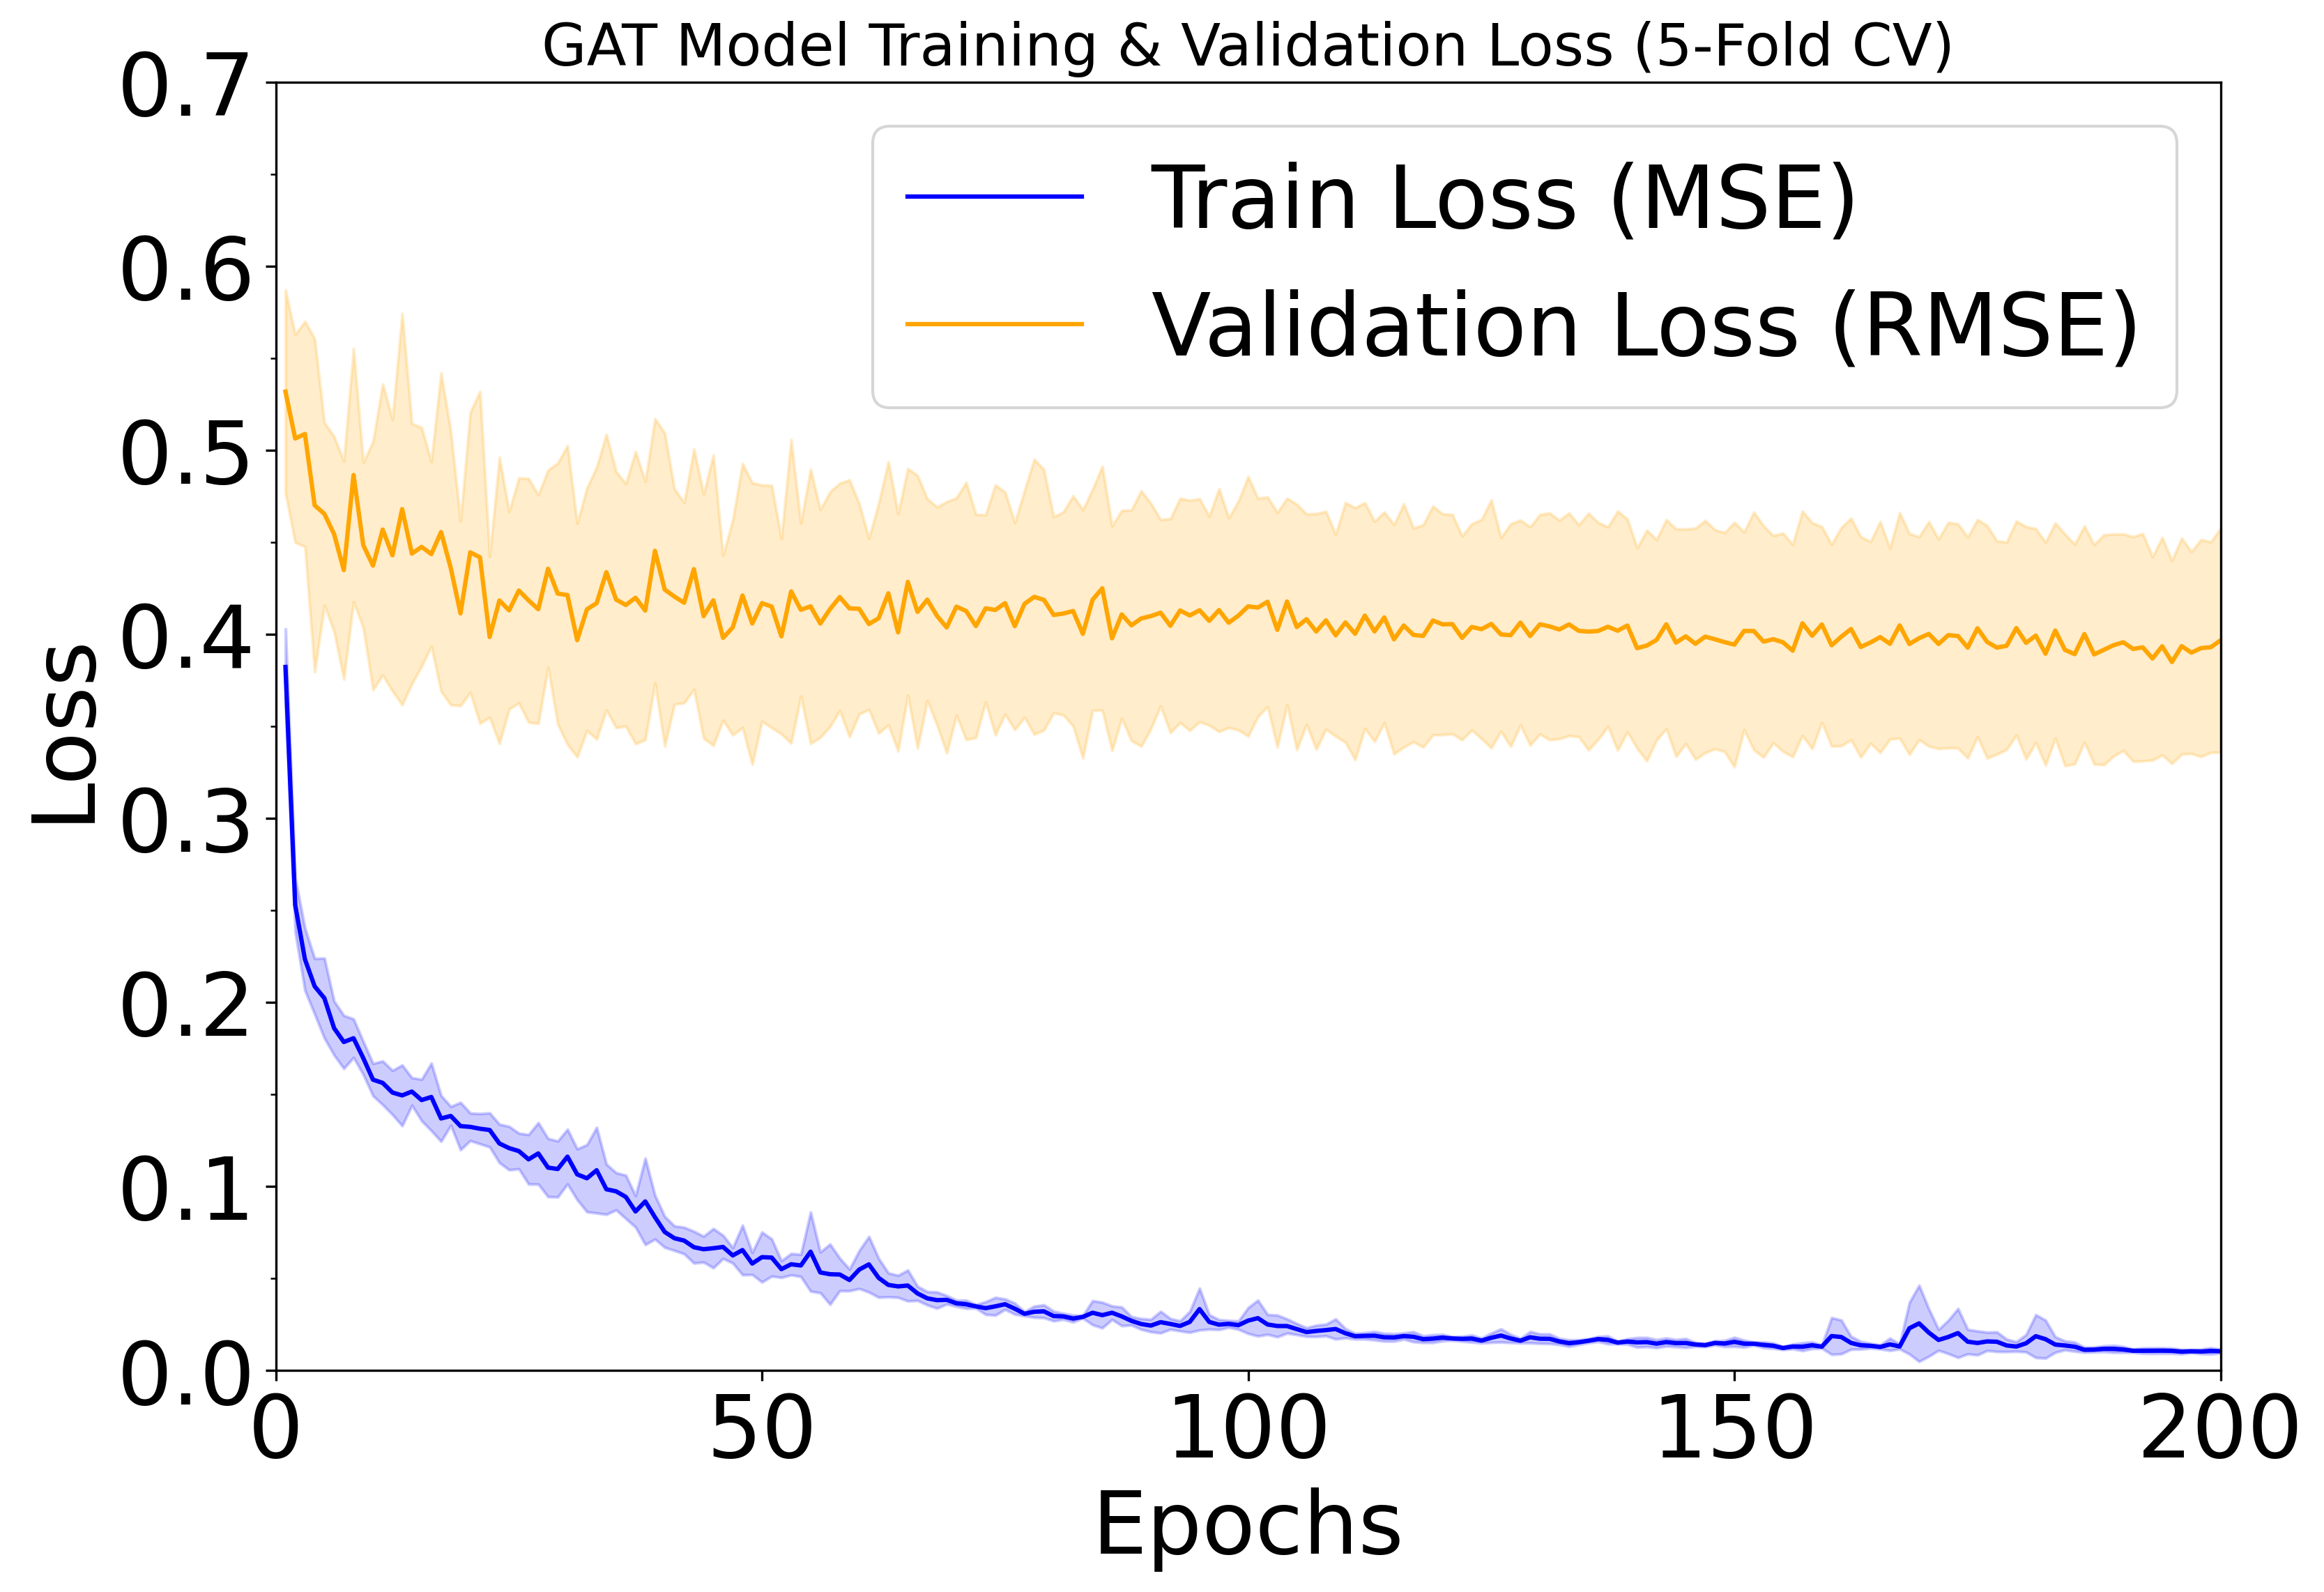

In [18]:
# --- Plot Average Loss Curves ---
plt.figure(figsize=(12, 8),dpi=300)

max_epochs_run = max(len(losses) for losses in all_val_losses_cv) if all_val_losses_cv else args.epochs

padded_train_losses = [l + [np.nan]*(max_epochs_run - len(l)) for l in all_train_losses_cv]
padded_val_losses = [l + [np.nan]*(max_epochs_run - len(l)) for l in all_val_losses_cv_rmse] #all_val_losses_cv]

avg_train_loss = np.nanmean(padded_train_losses, axis=0)
std_train_loss = np.nanstd(padded_train_losses, axis=0)
avg_val_loss = np.nanmean(padded_val_losses, axis=0)
std_val_loss = np.nanstd(padded_val_losses, axis=0)

epochs_axis = range(1, max_epochs_run + 1)

plt.plot(epochs_axis, avg_train_loss, label='Train Loss (MSE)', color='blue')
plt.fill_between(epochs_axis, avg_train_loss - std_train_loss, avg_train_loss + std_train_loss, color='blue', alpha=0.2)

plt.plot(epochs_axis, avg_val_loss, label=f'Validation Loss (RMSE)', color='orange')
plt.fill_between(epochs_axis, avg_val_loss - std_val_loss, avg_val_loss + std_val_loss, color='orange', alpha=0.2)

plt.title(f'GAT Model Training & Validation Loss ({k_folds}-Fold CV)', fontsize=20)
plt.xlabel('Epochs', fontsize=30)
plt.ylabel('Loss', fontsize=30)
plt.legend(fontsize=30)
#plt.grid(True)
plt.xlim(0, max_epochs_run)
min_loss_val = np.nanmin(avg_val_loss - std_val_loss) if not np.all(np.isnan(avg_val_loss)) else 0
max_loss_val = np.nanmax(avg_val_loss + std_val_loss) if not np.all(np.isnan(avg_val_loss)) else 1
min_loss_train = np.nanmin(avg_train_loss - std_train_loss) if not np.all(np.isnan(avg_train_loss)) else 0
max_loss_train = np.nanmax(avg_train_loss + std_train_loss) if not np.all(np.isnan(avg_train_loss)) else 1
plt.ylim(0, 0.7) #max(max_loss_val, max_loss_train) * 1.1)

# increase font size of ticks
plt.tick_params(axis='both', which='major', labelsize=20)
# add 1 minor ticks between each major tick
ax = plt.gca()
from matplotlib.ticker import AutoMinorLocator
ax.yaxis.set_minor_locator(AutoMinorLocator(2))

# increase font size of ticks
plt.tick_params(axis='both', which='major', labelsize=30)
plt.savefig('../Figures/GAT_tmqm_kfold-cv_435.png', transparent=True, bbox_inches='tight')